# Bayesian Neural Nets and how to train them
> An intuitive review of training bayesian neural nets

- toc: true 
- badges: true
- comments: true
- categories: [bayesian neural net]

In [1]:
#hide
# conda install -c conda-forge jupyter_contrib_nbextensions
# https://stackoverflow.com/questions/41241984/equation-numbering-in-jupyter-notebooks
#!pip install altair 
#!pip install pytorch-lightning pytorch-lightning-bolts
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim.optimizer import Optimizer
import copy
import random

import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import scipy.stats

# Why bayesian neural nets

- Robustness: Bayesian neural nets should, at least in theory and there has been some evidence for it, be more robust against out of sample data.
- Bayesian framework can incorporate prior information into the models.
- Bayesian models can present their uncertainty about a specific outcome, i.e. they can tell when they are uncertain!

## References
This post have used the following references extensively:
- Nemeth, C., & Fearnhead, P. (2019). Stochastic gradient Markov chain Monte Carlo, 1–31. Retrieved from http://arxiv.org/abs/1907.06986
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubon, D. B. (n.d.). Bayesian Data Analysis Third Edition. Retrieved from https://the-eye.eu/public/Books/qt.vidyagam.es/library/Monitoring and Analysis/Bayesian Data Analysis%2C Third Edition/Bayesian Data Analysis%2C Third Edition - Andrew Gelman %26 John B. Carlin %26 Hal S. Stern %26 David B. Dunson %26 Aki Vehtari %26 Dona
- Zhang, R., Li, C., Zhang, J., Chen, C., & Wilson, A. G. (2019). Cyclical Stochastic Gradient MCMC for Bayesian Deep Learning, (2017), 1–28. Retrieved from http://arxiv.org/abs/1902.03932

# General setup
We have a dataset $D = [\{x_i, y_i \}, i=1,...,n]$, and have defined a likelihood function $P(D|\theta)$ where $\theta \in R^d$ are some parameters defined in the model. We have also already defined a prior for these parameters $P(\theta)$. The posterior distribution can then be written as

\begin{equation} \tag{posterior}
P(\theta | D) = \frac{P(D|\theta) * P(\theta)}{P(D)} \propto P(D|\theta) * P(\theta)
\end{equation}

Finding $P(D)$ is impossible for all but the simplest cases, and as we are interested in complicated likelihood functions such as neural networks, it will clearly not work for us. 
Therefore, we only have the posterior distribution up to a constant.
Luckily, there has been developed multiple techniques that can find an approximation to the posterior distribution that only requires 
There exist multiple techniques to infer the posterior distribution of a bayesian neural network:
- Variational Inference
- Dropout
- SWAG
- Markov Chain Monte Carlo
- Stochastic Markov Chain Monte Carlo (SG-MCMC)

We will focus on the last two here.

## Motivating example
Throughout the post we will use a motivating problem to show what we mean.
Assume we have collected $N$ data points $(x_n, y_n), n\le N$ where $x_n \in R^2$ is a two dimensional vector, and $y_n \in R^1$ is a one dimensional response.
We generate the data using a very simple "neural net":
$$y_n = \beta_0 + \beta x_n + N(0,\sigma)$$

where $\beta_0$, $\beta$ and $\sigma$ are the parameters of the model. 
We will collect all three parameters in the parameter $\theta := \{ \beta_0, \beta, \sigma \}$ just to make it easier to write.

We can see that given both the input data $x_n$ and the parameters $\theta$ y_n is actually normally distributed.
That is what we call the likelihood function:

$$ P(D|\theta) = \prod_{n=1}^N P(y_n | \theta, x_n) = \prod_{n=1}^N N(\beta_0 + \beta x_n ,\sigma)$$

Let us generate a dataset with $\beta_0 = -1$, $\beta = 2.0$ and $\sigma = 0.1$:

In [2]:
N = 30
beta0 = torch.tensor([-1.0])
beta_true = torch.tensor([2.0])
sigma_true = torch.tensor([0.5])

X = dist.Uniform(-1,1).sample((N,))
Y = beta0 + X *beta_true + sigma_true*torch.normal(0,1, (N,))
data = {'x' : X,'y' : Y}

(
    alt.Chart(pd.DataFrame(data)).mark_circle(size=60)
    .encode(
        x='x',
        y='y')
    .properties(title="X versus Y in the real data")
    #.interactive()
)

alt.Chart(...)

Now, the goal in supervised learning is to find an estimate of the parameters $\theta$.
Our objective is to maximize the likelihood function plus a prior belief of what the parameters could be.
In this example we'll make a really stupid belief and say that it is equally possible to find the parameters anywhere on the real line: $P(\theta) \sim 1$.
This simplifies the analysis, and we can then write the posterior as proportional to the likelihood only:

$$
P(\theta | X,Y) \sim \prod_{n=1}^N N(y_n | \beta_0 + \beta x_n ,\sigma^2)
$$

We can implement this model in pytorch in the following way:

In [3]:
class BayesNet(nn.Module):
    def __init__(self, seed = 42):
        super().__init__()
        torch.random.manual_seed(seed)
        # Initialize the parameters with some random values
        self.beta0 = nn.Parameter(torch.randn((1,)))
        self.beta = nn.Parameter(torch.randn((1,)))
        self.sigma = nn.Parameter(torch.tensor([1.0]) ) # this has to be positive
    
    def forward(self, data: dict):
        return self.beta0 + self.beta*data['x']

    def loglik(self, data):
        # Evaluates the log of the likelihood given a set of X and Y
        yhat = self.forward(data)
        logprob = dist.Normal(yhat, self.sigma.abs()).log_prob(data['y'])
        return logprob.sum()

    def logprior(self):
        # Return a scalar of 0 since we have uniform prior
        return torch.tensor(0.0)
    
    def logpost(self, data):
        return self.loglik(data) + self.logprior()

In [4]:
model = BayesNet(seed =42)
model.loglik(data)

tensor(-68.5243, grad_fn=<SumBackward0>)

In [5]:
#hide
Finally, due to the sampling of data, we may note that the maximum likelihood estimation is slightly off the real parameters:
beta, beta0, r_value, p_value, std_err = scipy.stats.linregress(data['x'], data['y'])
print(f"MLE estimates: beta_0 = {beta0:.2f}, beta = {beta:.2f}")

MLE estimates: beta_0 = -0.92, beta = 1.93


# Markov Chain Monte Carlo (MCMC)
MCMC is the "traditional" way of finding the posterior distribution.
It is an iterative algorithm (the markov chain name) that is updating the belief of what the model parameters $\theta$ should be. I.e. we end up with a loong chain of parameter values: $\theta_1, \theta_2, ..., \theta_{n}$. 
However, we are not looking for a fixed value, but a distribution. Luckily, there are theory that tells us that if you run this sequence for long enough, then all values $\theta_n$ will be samples from the posterior distribution. Voila!

So how does it work? 


## Metropolis MCMC algorithm
The metropolis MCMC algorithms does nothing but starting in some random position $\theta_0$ and randomly tries to go in a direction (e.g. add a Normal distribution $\theta_1 = \theta_0 + N(0,1)$). 
If we improved (meaning that $P(\theta | D)$ increased) we use that new value. 
If it didnt improve, we may still move to that point depending on some probability.

Formally the algorithm looks like this:

1. Initialize a starting point $\theta_0$. This can either be random or somewhere you think is reasonable. For instance, you can start in the center of your prior distribution $argmax_{\theta} P(\theta)$.
2. For each $n=1,2,3,...$ do the following:
   1. Sample a proposal $\theta_*$ using a proposal distribution: $\theta_* \sim J(\theta_* | \theta_{n-1})$ 
   (for example a multivariate Normal distribution: $J(\theta_* | \theta_{n-1}) = N(\theta_* | \theta_{n-1}, \alpha I)$)
   2. Compute "how much better this proposal is than the previous:
   
   $$ 
   r = \frac{P(\theta_*|D)}{P(\theta_{n-1}|D)} 
   $$

   3. Set  
   
$$
\theta_n = 
\begin{cases} 
    \theta_* & \text{with probability} \text{ min}(1,r) \\
    \theta_{n-1} & \text{if not}
\end{cases}
$$

There is _one_ technical constraint on this proposal distribution $J$ and that is that it should be symmetric.
That means it should be just as likely to go in either direction: $J(\theta_a | \theta_b) = J(\theta_b | \theta_a)$. 
Our example above, a multivariate normal with the previous step as mean, satisfy this requirement.

So why should this thing work? First, see that if we get a better set of parameter then $P(\theta_*|D) > P(\theta_{n-1}|D)$ and the ratio is above 1. Then we will _always_ move to the new value (with probability 1)!
That is comforting. If I stand somewhere on a smooth mountain and only take a step whenever that step is upwards I can be pretty certain I reach the top!

But what about that second term? What if we actually dont improve? Looking at the algorithm, that is the case when r is less than 1.
We then have a positive possibility of moving anyways. Intuitively this is important for two reasons: 

1. We want to find a posterior _distribution_ at the end. If we only moved whenever we improved we would end up with a final value.
Actually moving in slightly worse directions will allow our parameters to wiggle around the optimal solution a little bit. 
And luckily, this kind of wiggling will give us the posterior distribution!
2. Having a positive probability of moving in wrong directions also gives us a chance to avoid local minima. In fact, since our proposal distribution has a positive probability of jumping to _any_ set of parameter values from any point, one can prove that the metropolis mcmc algorithm will find the optimum if it just runs for long enough.

### Step size aka learning rate
Given that we choose a gaussian proposal distribution with mean of the previous parameter set, we still need to set the covariance matrix of the distribution. 
In the example above it was $\alpha I$, where $\alpha > 0$ and $I$ is the identity matrix.
Given this parameterization $\alpha$ determines how far we should try to jump in the metropolis algorithm.
A large $\alpha$ will make us often jump far, whereas a small $\alpha$ will make us jump shortly.
If we do short jumps we are likely to get proposal parameters that does not perform too bad and the metropolis algorithm will often accept the new parameters, but we will take very short steps each time.
On the other hand, if we do large jumps we may sometiems get very good gains, but they will also be very bad very often. Therefore larger values of $\alpha$ will cause the accept probability to be low, but with large gains whenver it accepts.

This trade off looks very similar to learning rates in deep learning: Small steps will converge but slowly, and large steps takes giant leaps of faith and may not converge very well. The difference is of course that the metropolis algorithm will just not accept any proposals if you set $\alpha$ too high.
There are more complicated algorithms that tries to auto-set $\alpha$, but for now we will just find a reasonable value (by trial and error) and stick to it.

## Implementation of Metropolis algorithm
Let us implement a small "optimizer" that finds the posterior distribution using the metropolis algorithm.
The main component of this class is the `step()` function, and it goes through the steps above.
In addition we have implemented a `fit()` function for the training loop and a dictionary that holds all the parameters values over iterations so we can look at them later:

In [6]:
class MetropolisOptimizer():
    def __init__(self, net, alpha):
        super().__init__()
        self.net = net
        self.alpha = alpha
    
    @torch.no_grad()
    def step(self, data=None):
        # Step 1:
        proposal_net = copy.deepcopy(self.net) # we copy the whole network instead of just the parameters for simplicity
        for name, par in proposal_net.named_parameters():
            newpar = par + torch.normal(torch.zeros_like(par), self.alpha)
            par.copy_(newpar)
        
        # Step 2: calculate ratio
        ratio = torch.exp(proposal_net.logpost(data) - self.net.logpost(data))

        # Step 3: update with some probability:
        if (random.random()<ratio).bool():
            self.net = proposal_net
        else:
            pass
        return self.net

    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
        self.parameter_trace = {
            key : torch.zeros( (num_steps,) + par.size()) for key, par in self.net.named_parameters()}

        for s in range(num_steps):
            current_net = self.step(data)
            for key, val in current_net.named_parameters():
                self.parameter_trace[key][s,] = val.data

model = BayesNet()
trainer = MetropolisOptimizer(model, alpha=0.02)
# Train the model (and take the time):
%time trainer.fit(data, num_steps=5000)

CPU times: user 3.73 s, sys: 21 µs, total: 3.73 s
Wall time: 3.73 s


We only have 3 parameters and can visualize all of them.
We see that all three variables first trods its way towards the area were its "supposed to be" and then starts wiggling around that area. This is the posterior distribution!
In addition, we visualize a two dimensional plot of where $\beta_0$ and $\beta$ are over all steps:

In [7]:
#hide_input
def plot_parameter_trace(trainer):
    trace = pd.DataFrame({key : val.flatten() for key, val in trainer.parameter_trace.items()})
    chart = alt.vconcat()
    for col in trace.columns.to_list():
        ch = (
            alt.Chart(trace.reset_index()).mark_line()
            .encode(
                x="index",
                y=col
            )
            .properties(
                width=300,
                height=100
            )
        )#.interactive()
        chart &= ch

    twodim = (
        alt.Chart(trace.reset_index())
        .mark_circle(size=10)
        .encode(
            x="beta0",
            y="beta",
            color="index"
        )
        .properties(
                width=300,
                height=300
            )
    ).interactive()

    chart |= twodim
    return chart
plot_parameter_trace(trainer)

alt.HConcatChart(...)

All parameters starts in some random position and then quickly iterates itself towards where the posterior distributions should be. 
In the last plot we can see this over the two parameters $\beta$ and $\beta_0$ where they start in the lower right area and end up around there posteiror distribution in the upper left region.

The iterations before the model has converged to its posterior distribution (happens at around step 1500 or so) is called the **burn-in phase**, or it would just be called "training" in a standard deep learning setting.
However, in bayesian deep learning, this is where the fun starts, because now the mcmc starts to describe the full posterior distribution.
These two phases are very clear in the lower right plot!


# Langevin diffusion and approximate gradients
Metropolis MCMC is a fairly simple algorithm.
It even requires us to do a step in a random direction at each step, when its obvious we can often do better.
For instance, it would be smart to use the gradient of our distirbution function to move towards an area where $P(\theta| D)$ is larger.

The building block for doing so is the Langevin diffusion. 
Let us first write the unnormalized posterior as $P(\theta | D) \sim e^{-U(\theta)}$,
where we have introduced the potential energy function $U(\theta) := -log P(D|\theta) - log P(\theta)$.
Usually this function can be decomposed into a sum over the prior and all data points: 
$U(\theta) = \sum_{n=1}^N U_i(\theta) := \sum_{n=1}^N -log(f(y_i|\theta)) - \frac{1}{N}log(P(\theta))$.
In our motivating example U simply becomes $U(\theta) = -\sum_{n=1}^N log(N(y_n | \beta_0 + \beta x_n ,\sigma^2))$.

We can define the langevin diffusion, which is a stochastic differential equation:
\begin{equation}
\theta(t) = -\frac{1}{2} \nabla U(\theta(t))dt + dB_t
\end{equation}

Stochastic differential equations are intutively the same as normal differential equation, just that they have a randomness element $dB_t$ (a brownian motion).
We will not dwelve too much about that here, but think of it simply as a random walk that disturbs the direction we set in the first term.

So why do we talk about this langevin differential equation? 
It turns out that the **stationary distribution of the equation above is in fact the posterior distribution** we are looking for!
So, if we are able to simulate that process over a long time we will actually get samples from the posterior distribution!
Of course, solving differential equations are difficult to do analytically.
However, just like normal differential equations we can approximate a stochastic differential equation by an linear approximation using a small step size $\alpha$:

\begin{equation}
\theta(t+\alpha) = \theta(t) -\frac{\alpha}{2} \nabla U(\theta(t)) + \alpha*z
\end{equation}
where $z$ is a d-dimensional standard gaussian random variable.

By simulating from this approximation we can obtain the posterior distribution.
This equation looks surprisingly similar to the gradient descent algorithm: We update the current parameters by moving a small step towards the gradient of our objective. 
There are two main differences: 
The langevin diffusion adds a small noise factor $\alpha z$. 
It also requires us to evaluate the gradient of $U$ for all datapoints. This is unpractical on many datasets and the deep learning litterature usually approximate the gradient by an unbiased estimate at each iteration by subsampling the data
$$
\hat{\nabla} U(\theta) = \frac{N}{|S|} \sum_{i \in S} \nabla U_i(\theta)
$$
where $S$ is a random sample of $|S|$ number of datapoints.


That gives us the SGLD algorithm! We simply simulate the langevin diffusion using small step sizes $\alpha$ and an estimate of the gradient $\hat{\nabla} U(\theta)$ by subsampling datapoints.
It is important to note that these two approximations (the discretization and the gradient estimation of the data) will not give us the _true_ posterior distribution. If we wanted to do this correctly, we should have added an accept/reject step in the algorithm. 
However, this will often be costly, as we would have had to estimate the full $U(\theta)$ whenever we wanted to do that.


## Implementation of the SGLD algorithm
The implementation of SGD algorithm requires us the calculate the gradient of the likelihood function. 
That is something deep learning frameworks are very good at.
On the other hand, the SGLD algorithm will always accept the proposed parameters, making the optimization algorithm much simpler than the previous metropolis algorithm (at the risk of being a bad approximation to the posterior).
For this implementation, note that we do not subsample the data, as we only have 30 anyways.


In [8]:
from torch.optim.optimizer import Optimizer
class TrainOptimizerSGLD(Optimizer):
    def __init__(self, net, alpha=1e-4):
        super(TrainOptimizerSGLD, self).__init__(net.parameters(), {})
        self.net = net
        self.alpha = alpha
    
    def step(self, batch, batch_size=1, num_data=1):
        self.zero_grad()
        weight = num_data/batch_size
        loss = -self.net.loglik(batch)*weight - self.net.logprior()
        loss.backward()
        
        with torch.no_grad():
            for name, par in self.net.named_parameters():
                newpar = (
                    par - 0.5*self.alpha*par.grad 
                    + torch.normal(torch.zeros_like(par), std=self.alpha)
                )
                par.copy_(newpar)
        return loss

    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
        self.parameter_trace = {key : torch.zeros( (num_steps,) + par.size()) for key, par in self.net.named_parameters()}

        for s in range(num_steps):
            loss = self.step(data)
            for key, val in self.net.named_parameters():
                self.parameter_trace[key][s,] = val.data

model = BayesNet()
trainer = TrainOptimizerSGLD(model, alpha=0.02)
# Train the model (and take the time):
%time trainer.fit(data, num_steps=5000)
plot_parameter_trace(trainer)

CPU times: user 3.8 s, sys: 18.6 ms, total: 3.82 s
Wall time: 3.82 s


alt.HConcatChart(...)

Compared to the metropolis algorithm we see that the beta parameters quickly snap into place.
However, the sigma parameter is varying much more than anticipated. 
This must be due to the approximation error in the discretization of the stochastic differential equation.
Reducing step size should solve this problem:

In [9]:
model = BayesNet()
trainer = TrainOptimizerSGLD(model, alpha=0.005)
# Train the model (and take the time):
%time trainer.fit(data, num_steps=5000)
plot_parameter_trace(trainer)

CPU times: user 3.84 s, sys: 1.75 ms, total: 3.84 s
Wall time: 3.84 s


alt.HConcatChart(...)

Voila! Compared to the Metropolis algorithm, the SGLD snapped the $beta$ parameters pretty much straight into the correct area.
It shows a great speed improvement from the random walk algorithm of Metropolis, something which is cruical for more complicated problems.
At the same time, we can see that $\sigma$ never really converged to its true value around 0.5, but keeps jumping up.
This must be due to the Euler approximation in the Langevin diffusion, and should be solveable by reducing step sizes.
Let us repeat the SGLD algorithm with a smaller step size.
We see that although the convergence is slightly slower (but much faster than the metropolis!), we end up with a better approximation:

# Cyclical SG-MCMC (cSG-MCMC)
The last algorithm we shall go through is a recent ICML paper that utilizes cyclical stepsizes to capture a "better" posterior distribution.
They focus on the problem when a posterior distribution have multiple modes, or optimal "areas", in the parameter space.
This problem is typical for neural nets with their large parameter space.

The Cyclical SG-MCMC algorithm works as the SGLD algorithm above, but using varying step sizes. 
 The algorithm starts with a large step size (exploration mode) to quickly move towards an interesting mode then decreasing the step size gradually to capture the posterior distribution around the found mode (sampling mode). 
It repeats this procedure multiple times, being able to capture a multi-modal posterior distribution.
Finally it uses all parameter samples found in sampling mode as its posterior distributions.

![](assets-bayes-nn/cyclic-stepsize.png "Visualization of cyclical stepsize decay vs traditional stepsize decay")

The technique is similar to other MCMC algorithms that tries to reinitialize the MCMC chain in different points to find different modes.
However, this paper argues that using cycles will warm-start the network at each iteration, allowing it to start in a slightly smarter place and saving computational cost for the same performance.

Empirically they show that cSG-MCMC are able to find multiple modes whereas SGLD with 4 parallel iterations can only find 4:
![](assets-bayes-nn/multi-modal-synthetic.png "cSGLD are able to finding more modes than parallel SGLD.")

And they show that cSG-MCMC can achieve lower test errors than benchmark optimization algorithms:
![](assets-bayes-nn/cSG-mcmc-error.png "cSGLD test errors compared to non cyclical variant")


# Scaling sg-mcmc up to neural networks
So far we've been analyzing a simplistic example, but both cSG-MCMC and SGLD are clearly meant for larger datasets and neural networks.
We therefore change our dataset to the CIFAR-10 dataset, an image dataset with 10 classes.
Our likelihood is the Categorical Distribution, and we get the correct energy function $U(\theta)$ by applying the nn.CrossEntropy loss.
We utilize pytorch-lightning to structure the model, but the main ingredients are in the optimizer.

In [10]:
#hide 
from pl_bolts.datamodules import CIFAR10DataModule
import torch
from torch.nn import functional as F
from torch import nn
from torch.optim.optimizer import Optimizer
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer, seed_everything
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchvision
from pytorch_lightning.loggers import TensorBoardLogger

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


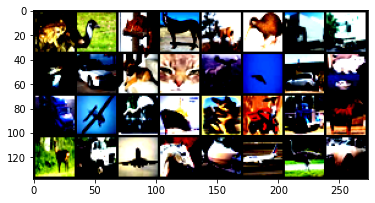

In [11]:
dataset = CIFAR10DataModule(data_dir=".")

# visualize a batch
x,y = next(iter(dataset.train_dataloader()))
_ = plt.imshow(torchvision.utils.make_grid(x).permute(1,2,0))


In [12]:
class OptimizerSGLD(Optimizer):
    """ Optimizer that allows for cyclic learning rate, stochastic mcmc and normal sgd."""
    def __init__(self, net, lr_max=1e-3, lr_min=1e-5, max_step = 10e3, noise=True):
        super(OptimizerSGLD, self).__init__(net.parameters(), {})
        self.net = net
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr = self.lr_max
        self.max_step = max_step
        self.it=0
        self.noise = noise
    
    @torch.no_grad()
    def step(self, batch_size=1, num_data=1):
        # Update learning rate:
        self.it +=1
        ratio = (self.it % self.max_step)/self.max_step
        self.lr = self.lr_max*(1-ratio) + self.lr_min*ratio
        self.net.log("learning_rate", self.lr)

        # Update parameters:
        for name, par in self.net.named_parameters():
            newpar = par - 0.5*self.lr*par.grad 
            if self.noise:
                newpar += torch.normal(torch.zeros_like(par), std=self.lr)
            par.copy_(newpar)
        

In [13]:
class LitMNIST(LightningModule):
    def __init__(self, lr_max=1e-3, lr_min=1e-5, max_step = 10e3, noise=True):
        super().__init__()

        self.layer_1 = nn.Conv2d(3, 16, 3)
        self.layer_2 = nn.Conv2d(16, 32, 3)
        self.linear1 = nn.Linear(1152, 128)
        self.linear2 = nn.Linear(128, 10)

        self.criterion = nn.CrossEntropyLoss()
        # Metrics
        self.train_acc = pl.metrics.Accuracy()
        self.val_acc = pl.metrics.Accuracy()

        # Initialize optimizer
        self.opt = OptimizerSGLD(self, lr_max, lr_min, max_step, noise=noise)


    def forward(self, x):
        batch_size, channels, width, height = x.size()
        x = F.relu(self.layer_1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.layer_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(batch_size,-1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def step(self, batch, batch_idx, phase):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.log(f"{phase}/loss", loss)
        if phase == "train":
            self.train_acc(logits,y)
        if phase == "val":
            self.val_acc(logits,y)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train")
    
    def validation_step(self, batch, batch_idx):
        for key, val in self.named_parameters():
            self.log(f'param/{key}', value = val.abs().mean())
        return self.step(batch, batch_idx, "val")

    def training_epoch_end(self, outs):
        self.log('train/accuracy', self.train_acc.compute())
        self.log("learning_rate", self.optimizers().lr)

    def validation_epoch_end(self, outs):
        self.log('val/accuracy', self.val_acc.compute())

    def configure_optimizers(self):
        return self.opt

## Comparing cSGMCMC vs SGLD vs SGD
Given our optimizer above it is easy to modify it to run different algorithms, and we will compare these three algorithms in a simple run.

In [14]:
configs = {
    'cSGMCMC' : {
        'max_step' : 30e3,
        'noise' : True
    },
    'SGLD' : {
        'max_step' : 1564*100,
        'noise' : True
    },
    'SGD' : {
        'max_step' : 1564*100,
        'noise' : False
    },
}

In [16]:
for name, config in configs.items():
    model = LitMNIST(lr_max=1e-3, lr_min=1e-5, **config)
    logger = TensorBoardLogger("logs", name=name)
    trainer = Trainer(gpus=1, progress_bar_refresh_rate=0, logger=logger, max_epochs=100)
    trainer.fit(model, dataset)
    print(f"Finished training {name}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Files already downloaded and verified
Files already downloaded and verified

  | Name      | Type             | Params
-----------------------------------------------
0 | layer_1   | Conv2d           | 448   
1 | layer_2   | Conv2d           | 4 K   
2 | linear1   | Linear           | 147 K 
3 | linear2   | Linear           | 1 K   
4 | criterion | CrossEntropyLoss | 0     
5 | train_acc | Accuracy         | 0     
6 | val_acc   | Accuracy         | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | layer_1   | Conv2d           | 448   
1 | layer_2   | Conv2d           | 4 K   
2 | linear1   | Linear           | 147 K 
3 | linear2   | Linear           | 1 K   
4 | criterion | CrossEntropyLoss | 0     
5 | trai